# Modules

In [1]:
pip install sklearn_som

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 30.1 MB/s 


In [3]:
pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9016 sha256=091b249cb01988c1dddd3bc3bd260d2f21881d5f6addd349782eede738e468e9
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


In [4]:
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
random.seed(14)

# Data

In [5]:
df = pd.read_excel("Time_Series_Merchants_Transactions_Anonymized.xlsx")

In [6]:
df2 = df.set_index('Merchant Name')

In [7]:
scaler = StandardScaler()
Scale_df = scaler.fit_transform(df2)
df_es = pd.DataFrame(Scale_df, columns=df2.columns)

In [8]:
df_es.columns = pd.Series(pd.period_range("8/1/2020", freq="M", periods=26))

In [9]:
df_tr = df_es.transpose(copy=True)

In [10]:
names = list(df_tr.columns)

In [12]:
Re = df_es.sample(n = 20)

In [13]:
Re = Re.transpose(copy=True)

In [15]:
Re_tr = df_es.transpose(copy=True)

In [16]:
Re_tr_1 = Re.transpose(copy=True)

In [17]:
Merchants = [f'Merchant {i+1}' for i in range(len(Re_tr.columns))]

In [18]:
Re_tr.columns = Merchants

In [21]:
value2 = df_es.to_numpy()

## 20 Random Plots to take a look to the data

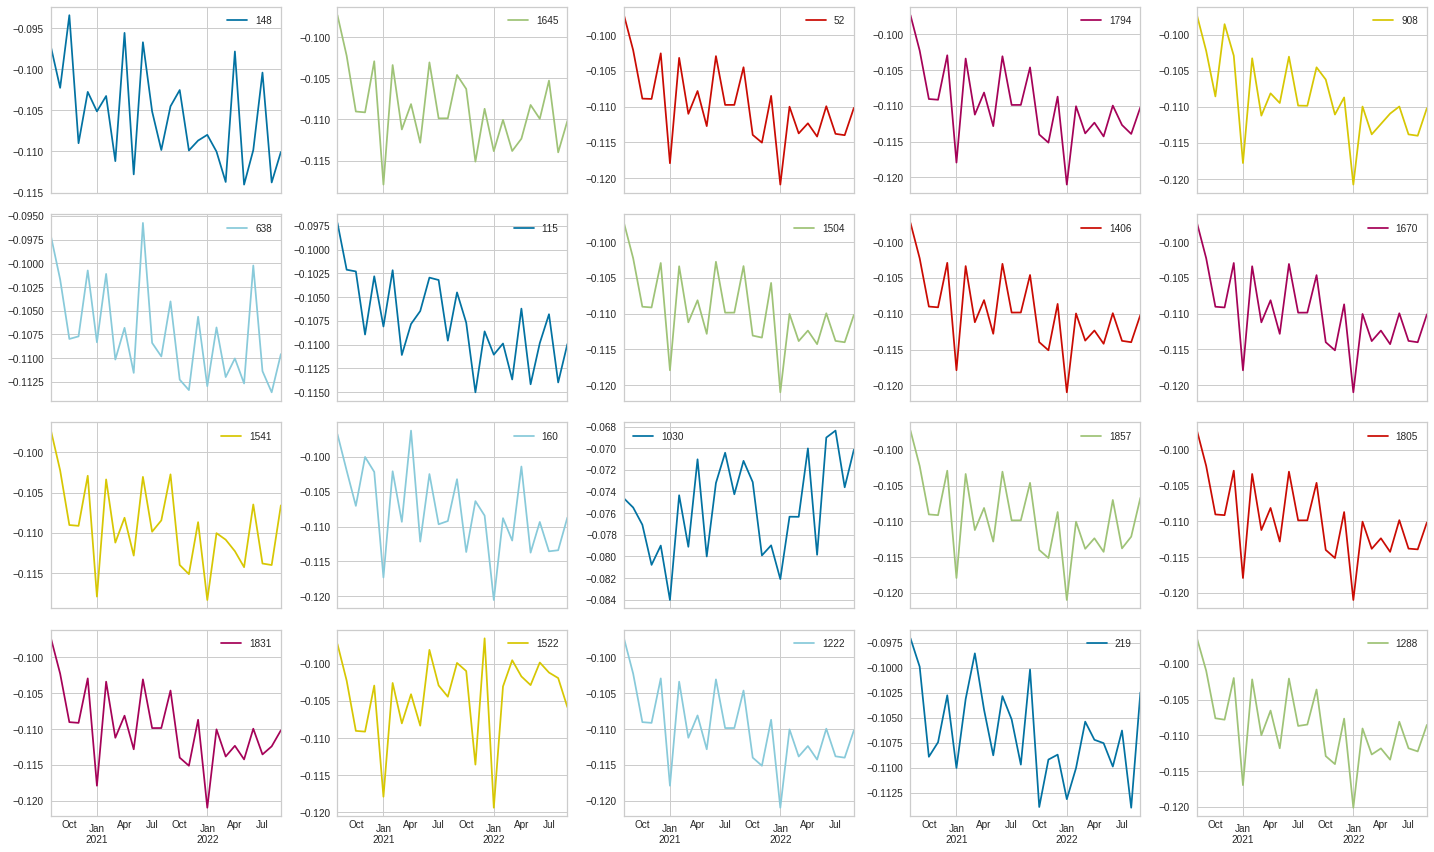

In [20]:
Re.plot(subplots=True, layout=(4,5), figsize=(20,12));
plt.tight_layout();
plt.show();

# CLUSTERING SOM

## ELBOW METHOD

In [23]:
cluster_errors = []
for i in range(1, 15):
    n_clusters = i
    kmeans_pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "cluster",
                KMeans(n_clusters=n_clusters, random_state=14, verbose=0, 
                       # n_jobs=1
                      ),
            ),
        ]
    )
    kmeans_pipeline.fit(df_es)
    kmeans_pipeline.predict(df_es)
    cluster_errors.append(kmeans_pipeline.named_steps["cluster"].inertia_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Period']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Period']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Period']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Period']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validat

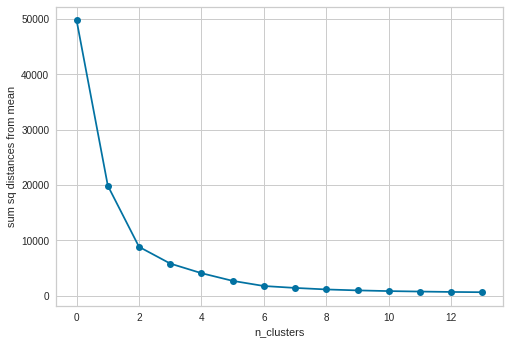

In [24]:
plt.clf()
plt.plot(cluster_errors, "o-")
plt.xlabel("n_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

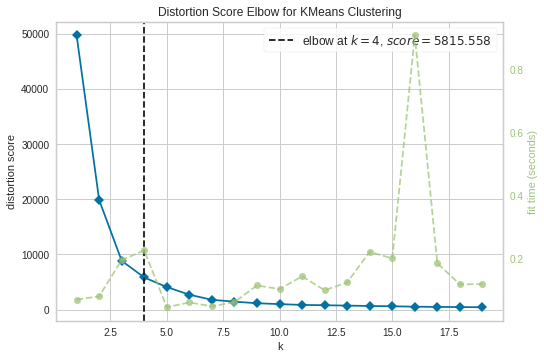

In [25]:
# List with Features:
features = list(df_es.columns)

# Setting up the content of variable 'X':
X = df_es.loc[:,features].values

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])
numeric_features = list(range(len(features)))

feature_encoder = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

X = feature_encoder.fit_transform(X)

# Clustering model and visualizer:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(X) # Fit the data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [26]:
mySeries = []
namesofMySeries = []
for i in range(len(df_es.iloc[:])):
    mySeries.append(df_es.iloc[i].to_numpy())
    namesofMySeries.append(f'Merchant {i+1}')

In [27]:
som_x = som_y = 2
som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)
som.random_weights_init(mySeries)
som.train(mySeries, 50000)

In [28]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

Averaging each series in the cluster

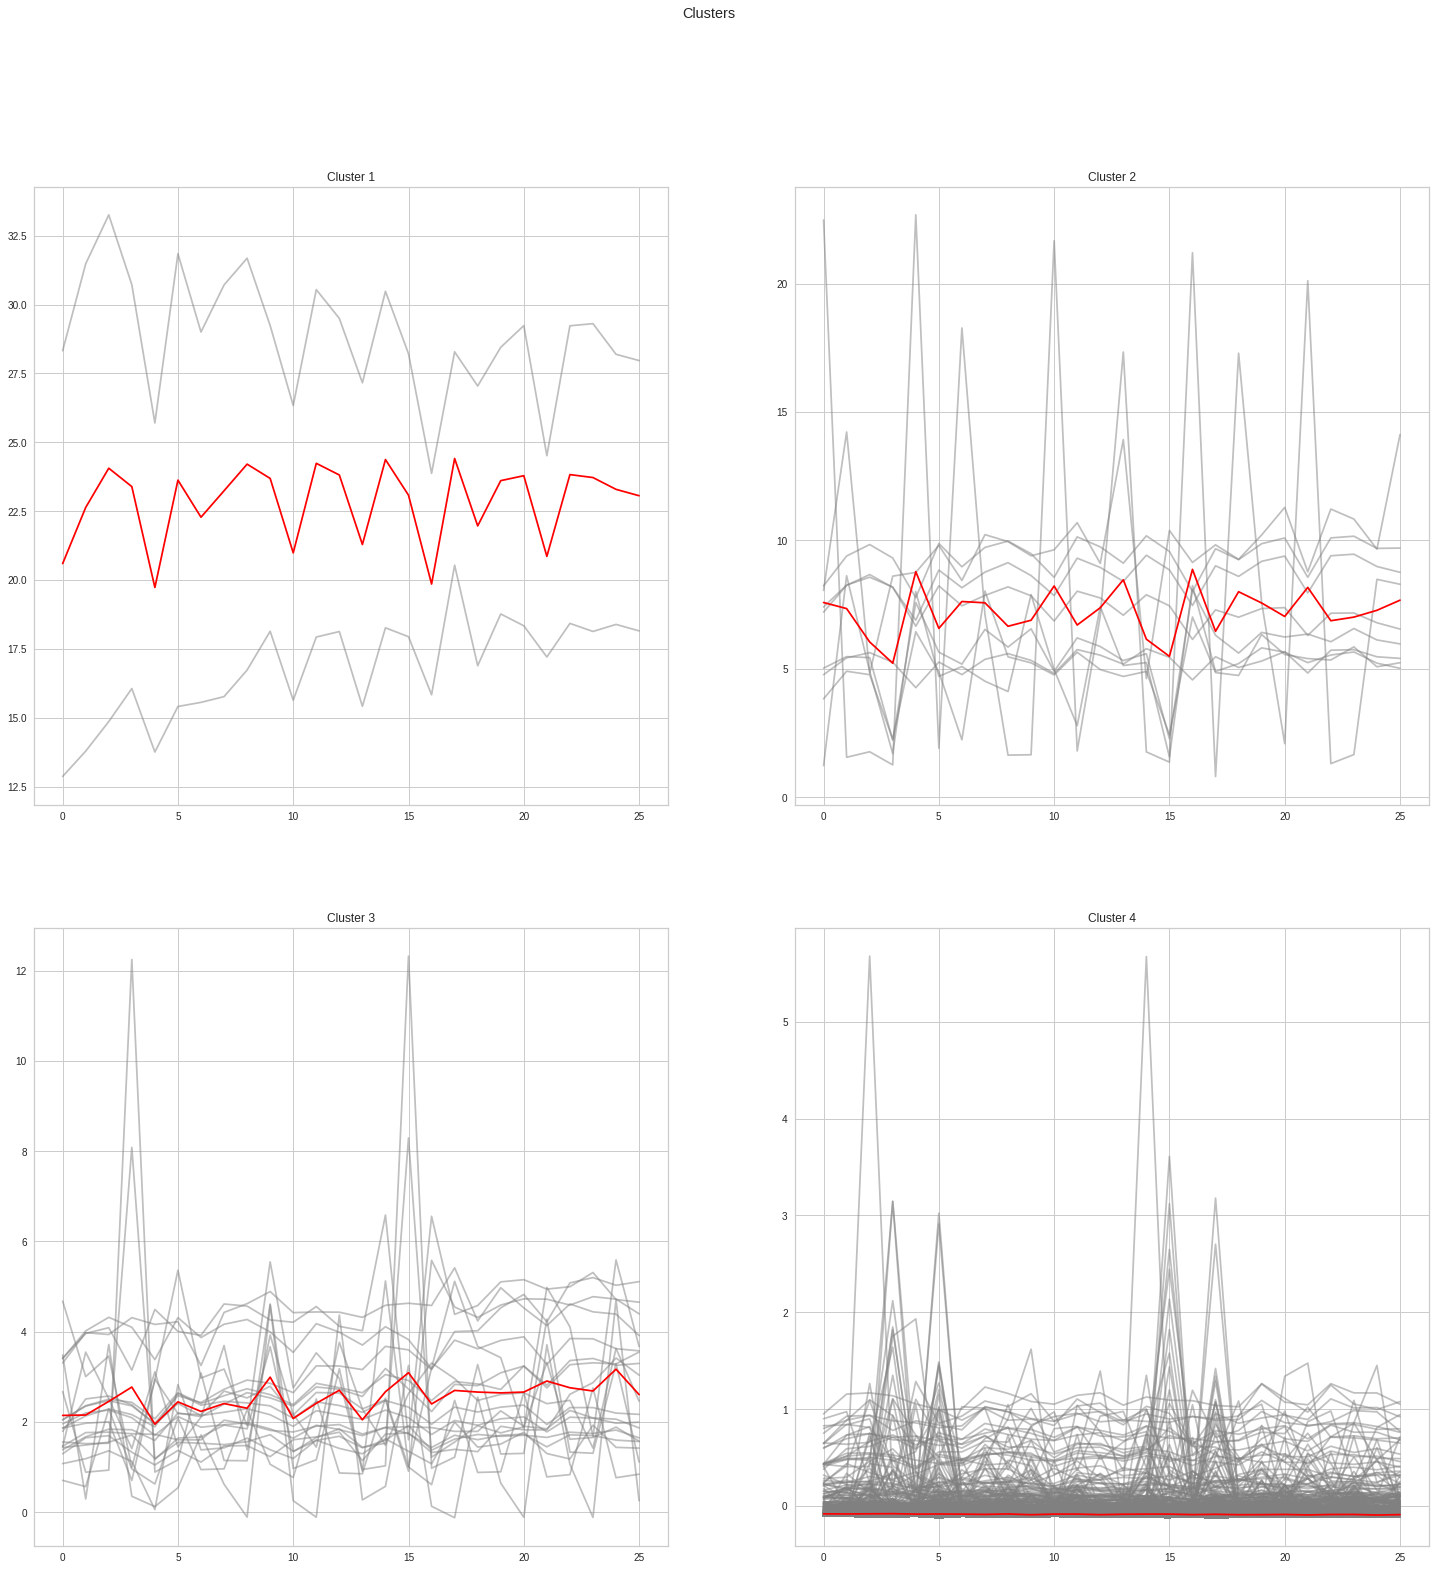

In [29]:
win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs
plot_som_series_averaged_center(som_x, som_y, win_map)

In [30]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(15,15))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

DBA stands for Dynamic Time Warping Barycenter Averaging. DBA is an averaging method that is consistent with Dynamic Time Warping.

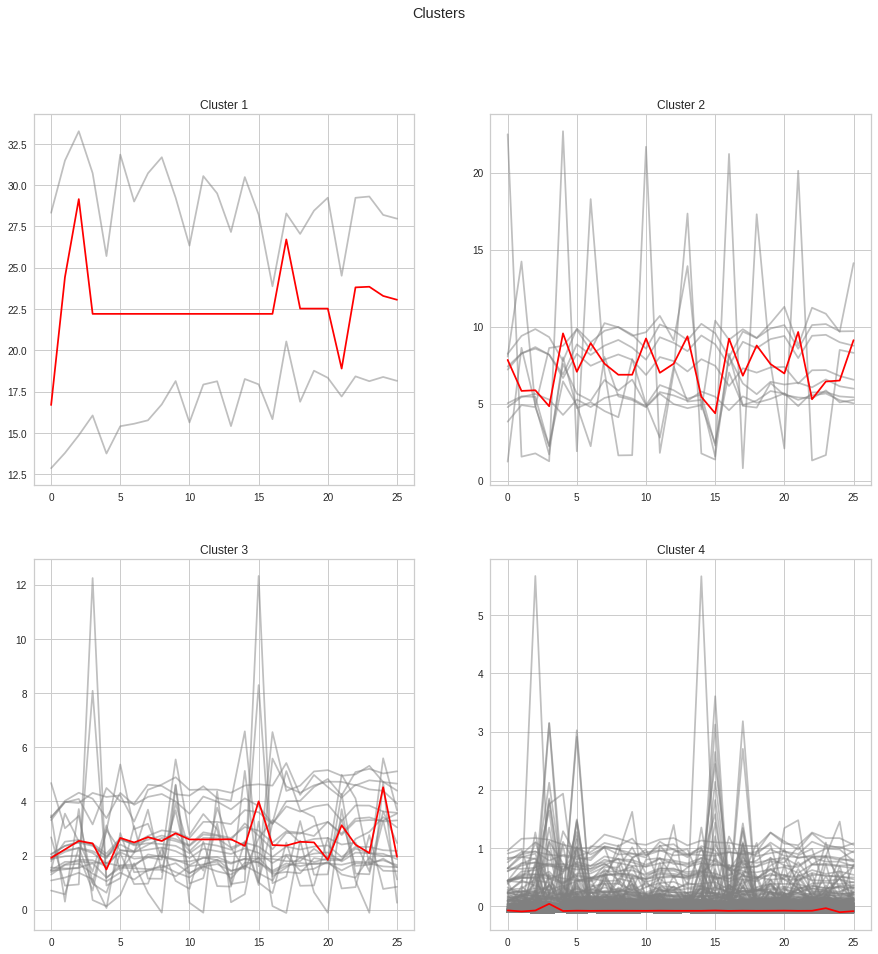

In [31]:
win_map = som.win_map(mySeries)
plot_som_series_dba_center(som_x, som_y, win_map)

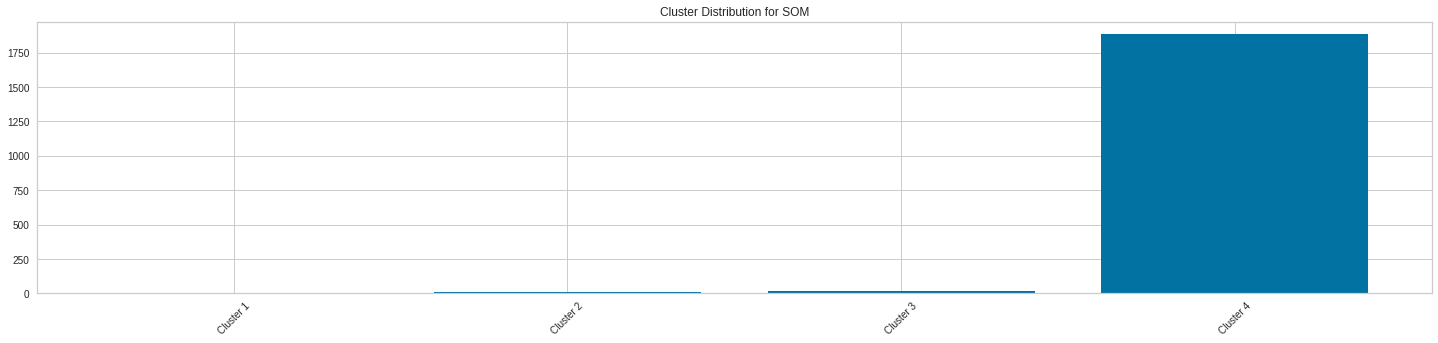

In [32]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.xticks(rotation = 45)
plt.show()

In [33]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

Clusters_SOM = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")
Clusters_SOM.value_counts()

Cluster  
Cluster 4    1882
Cluster 3      20
Cluster 2       9
Cluster 1       2
dtype: int64

In [34]:
Clusters_SOM

,Cluster
Series,
Merchant 1,Cluster 1
Merchant 439,Cluster 1
Merchant 589,Cluster 2
Merchant 425,Cluster 2
Merchant 378,Cluster 2
...,...
Merchant 641,Cluster 4
Merchant 640,Cluster 4
Merchant 639,Cluster 4


# CLUSTERING K-MEANS

## Selecting Dynamic Time Warping(DTW)

In [36]:
cluster_count = 4 # Based on Elbow Method
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
labels = km.fit_predict(mySeries)

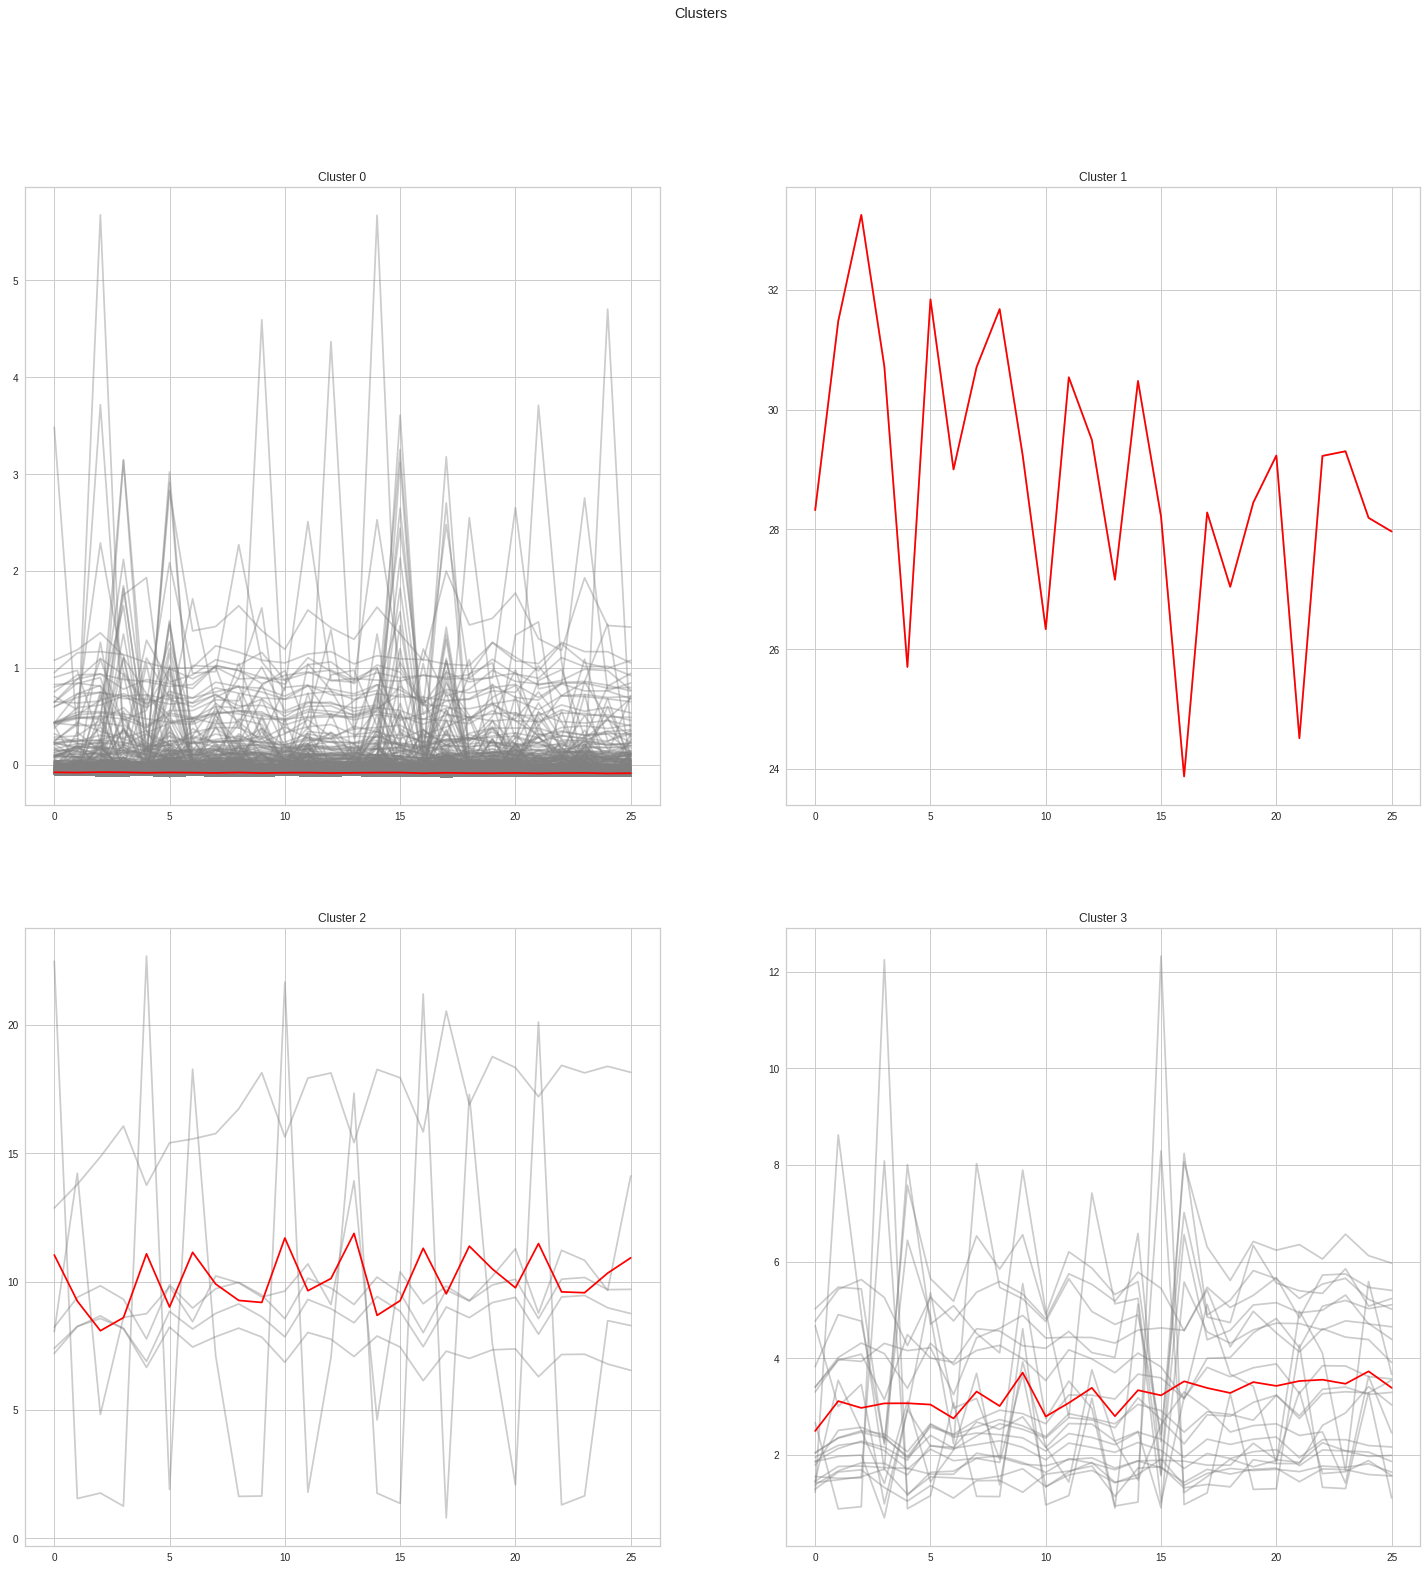

In [48]:
plot_count = math.ceil(math.sqrt(cluster_count))
fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

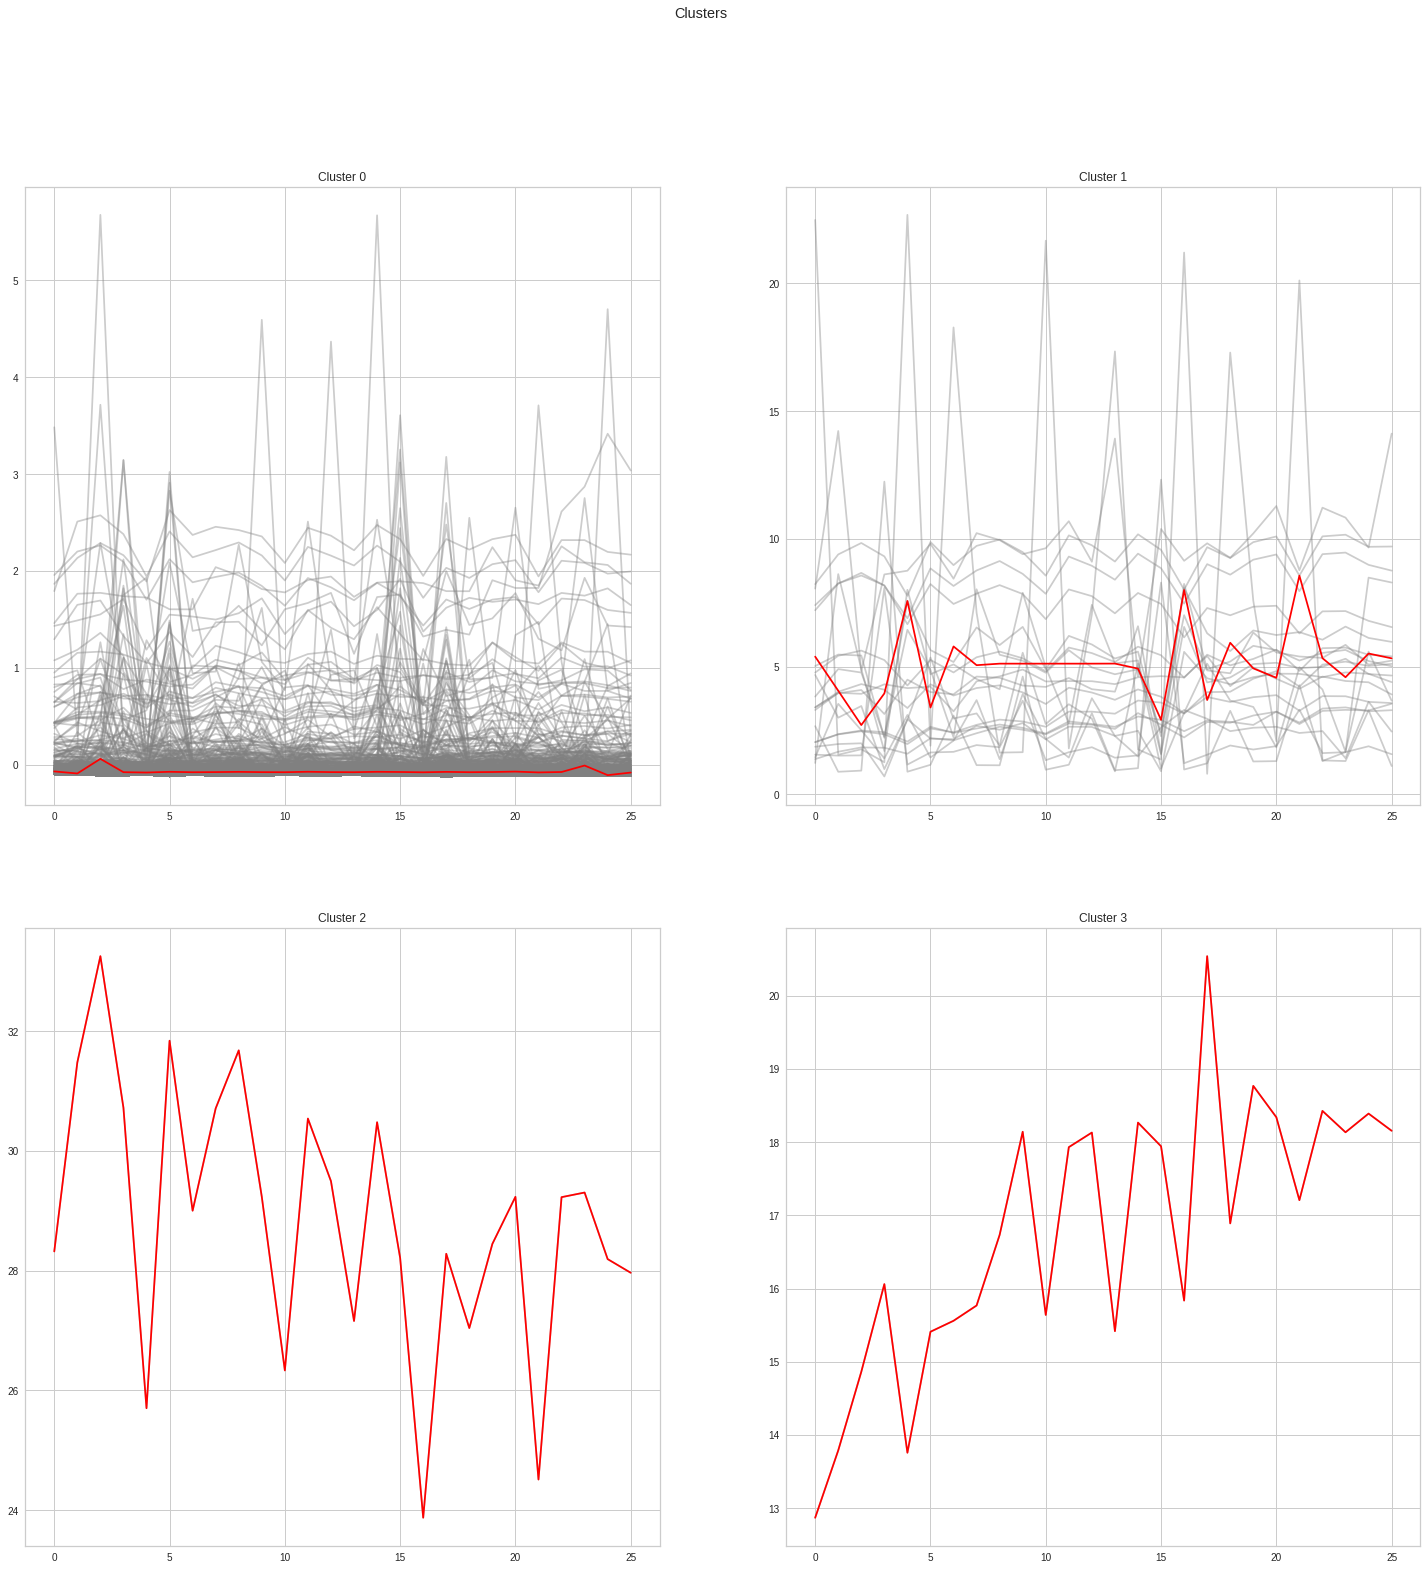

In [38]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

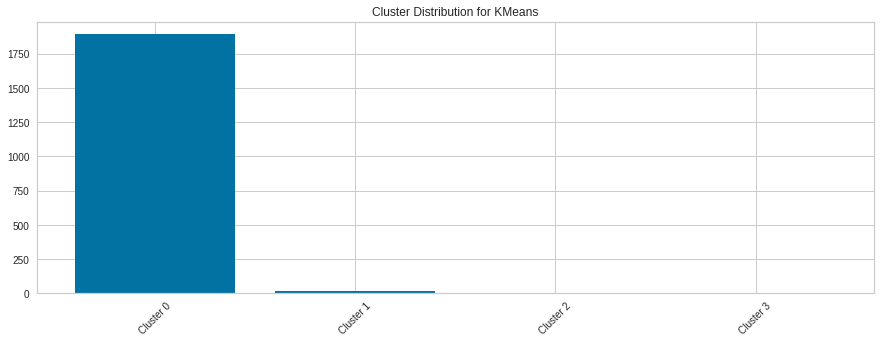

In [39]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.xticks(rotation = 45)
plt.show()

In [40]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
K_means_Cluster = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")
K_means_Cluster

,Cluster
Series,
Merchant 957,Cluster 0
Merchant 1283,Cluster 0
Merchant 1282,Cluster 0
Merchant 1281,Cluster 0
Merchant 1280,Cluster 0
...,...
Merchant 882,Cluster 1
Merchant 1027,Cluster 1
Merchant 619,Cluster 1


In [41]:
pca = PCA(n_components=2)
mySeries_transformed = pca.fit_transform(mySeries)